# Table of content
### 1. Import of libraries
### 2. Classes and functions


# 1. Import of libraries

In [ ]:
! pip install timm
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install datasets faiss-gpu git+https://github.com/NielsRogge/transformers.git@add_siglip sentencepiece



In [2]:
import pandas as pd
import os
import csv
from tqdm import tqdm
import numpy as np
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, AutoProcessor, AutoModel

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from random import sample
import clip
from pkg_resources import packaging
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'
device = "cuda" if torch.cuda.is_available() else "cpu"
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

In [3]:
print("Torch version:", torch.__version__,"device",device)

Torch version: 2.4.1+cu121 device cpu


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 2. Download dataset

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/P10"
%cd /content/gdrive/MyDrive/P10

/content/gdrive/MyDrive/P10


In [ ]:
#!kaggle datasets download -d paramaggarwal/fashion-product-images-dataset

In [ ]:
#!unzip /content/gdrive/MyDrive/P10/fashion-product-images-dataset.zip

In [ ]:
images_dir = "/content/gdrive/MyDrive/P10/fashion-dataset/images/"

In [ ]:
images = pd.read_csv("/content/gdrive/MyDrive/P10/fashion-dataset/images.csv")
images.shape

(44446, 2)

In [ ]:
number_of_img = [a for a in os.listdir(images_dir)]
len(number_of_img)

44441

Resources:
- https://paperswithcode.com
- https://huggingface.co/docs/transformers/v4.44.2/en/model_doc/blip-2#transformers.Blip2Processor
- https://huggingface.co/docs/transformers/model_doc/siglip
- Dataset : https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset?resource=download

# 2. Classes and functions

In [ ]:
def complete(lst, padding_length):
    for i in range(padding_length - len(lst)):
        lst.append(f'add_{i}')
    return lst

# 3. Preprocessing

Read style.csv

In [ ]:
with open("/content/gdrive/MyDrive/P10/fashion-dataset/styles.csv") as file:
    spamreader = csv.reader(file, delimiter=',')
    fashion_data = list()
    max_lenght = 0
    for row in spamreader:
        if len(row) > max_lenght:
            max_lenght = len(row)

In [ ]:
with open("/content/gdrive/MyDrive/P10/fashion-dataset/styles.csv") as file:
    spamreader = csv.reader(file, delimiter=',')
    fashion_data = list()
    for row in spamreader:
            line_filled = complete(row, max_lenght)
            fashion_data.append(line_filled)

In [ ]:
headers = fashion_data.pop(0)
style = pd.DataFrame(fashion_data, columns=headers)
style.loc[style['add_0']=='add_0', 'add_0'] = ''
style.loc[(style['add_1']=='add_1')|(style['add_1']=='add_0'), 'add_1'] = ''
style["productDisplayName"] = style["productDisplayName"] + style['add_0'] + style['add_1']
style = style.drop(columns=['add_0', 'add_1'])

Check if all images in style.csv is in my image directory. Delete those that are not.

In [ ]:
liste_style_id = list(style['id'].values)
liste_of_img = [a[:-4] for a in number_of_img]
len(liste_of_img), len(liste_style_id)

(44441, 44446)

In [ ]:
img_to_delete = [img for img in liste_style_id if img not in liste_of_img]
style = style[~style['id'].isin(img_to_delete)]

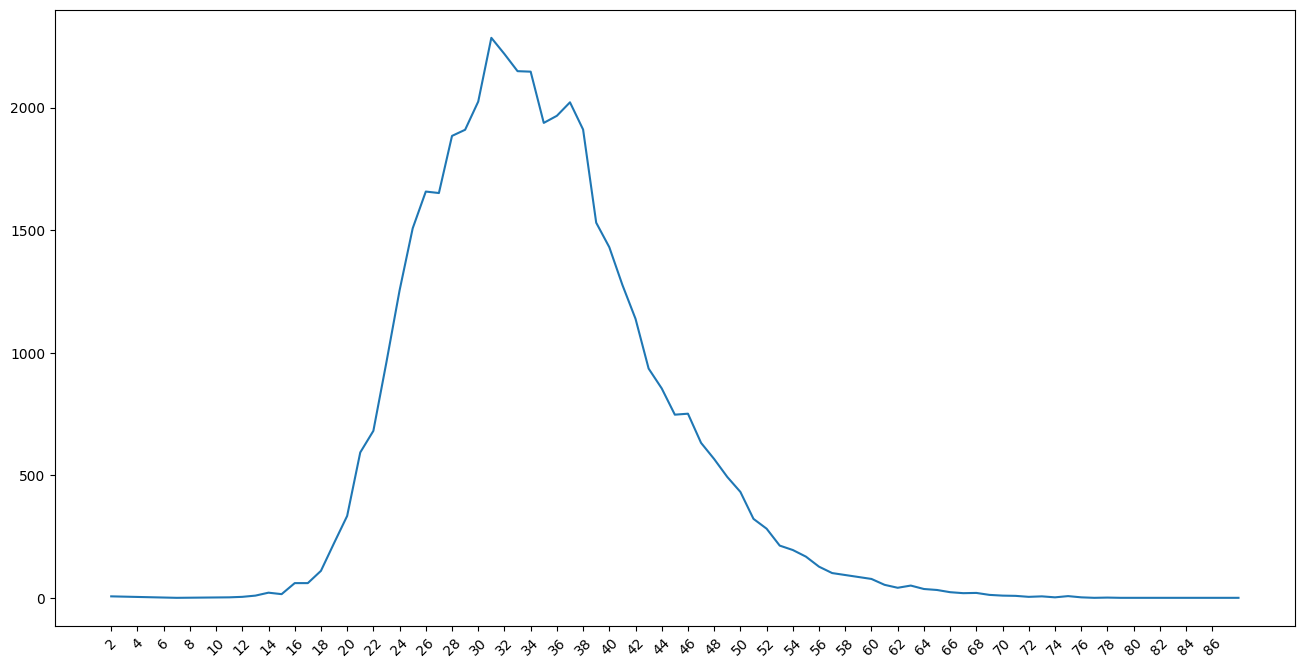

In [ ]:
# Distribution of descriptions length.
plt.figure(figsize=(16, 8))
plt.plot(style['productDisplayName'].str.len().value_counts().sort_index())
plt.xticks(np.arange(style['productDisplayName'].str.len().min(),style['productDisplayName'].str.len().max(), 2), rotation=45);

Remove rows with small description (less than 18 characters) and too long description (more than 60).

In [ ]:
style_trunc = style.loc[(style['productDisplayName'].str.len()>=18)&(style['productDisplayName'].str.len()<=60)]

In [ ]:
style_trunc['desc'] = style_trunc['productDisplayName'] + ' for ' + style_trunc['usage'] + ' usage in ' + style_trunc['season']
style_trunc['id'] = images_dir + style_trunc['id'].astype(str) + '.jpg'

<ipython-input-49-9806bb0fdc18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  style_trunc['desc'] = style_trunc['productDisplayName'] + ' for ' + style_trunc['usage'] + ' usage in ' + style_trunc['season']
<ipython-input-49-9806bb0fdc18>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  style_trunc['id'] = images_dir + style_trunc['id'].astype(str) + '.jpg'


In [ ]:
# Save clean dataset.
#style_trunc.to_csv("/content/gdrive/MyDrive/P10/fashion_dataset_clean.csv")

# 4. Modèle CLIP

Fine tuning : https://medium.com/aimonks/a-guide-to-fine-tuning-clip-models-with-custom-data-6c7c0d1416fb

In [5]:
from tqdm import tqdm
def top_k_indices(arr, k):
    return np.argsort(arr[-k:])

def create_sample_uniform(data, categorie_name, each_cat_size):
  cat_distribution = data[categorie_name].value_counts()
  col_over_size = cat_distribution[cat_distribution>=each_cat_size].index
  cat_under_size = cat_distribution[cat_distribution<each_cat_size].index
  sample = pd.DataFrame()
  for cat in col_over_size:
    sample = pd.concat([sample, data[data[categorie_name]==cat].sample(n=each_cat_size, random_state=42)])
  sample = pd.concat([sample, data.loc[data[categorie_name].isin(cat_under_size)]])
  return sample

class Dataloader():
  def __init__(self, data_dir):
    self.data_dir = data_dir

  def load_data(self):
    data = pd.read_csv(self.data_dir)
    return data

  def get_images_path(self, sample_size=None):
    if sample_size:
      images_path = self.load_data()['id'].sample(n=sample_size, random_state=42).to_list()
    else:
      images_path = self.load_data()['id'].to_list()
    return images_path

  def get_descriptions(self, sample_size=None):
    if sample_size:
      descriptions = self.load_data()['desc'].sample(n=sample_size, random_state=42).to_list()
    else:
      descriptions = self.load_data()['desc'].to_list()
    return descriptions

class Clip():
    def __init__(self, image_paths, descriptions, model):
      self.image_paths = image_paths
      self.descriptions = descriptions
      self.model, self.processor = clip.load(model,device=device)

    def info(self):
      input_resolution = self.model.visual.input_resolution
      context_length = self.model.context_length
      vocab_size = self.model.vocab_size
      print("Models available:", f"{clip.available_models()}")
      print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in self.model.parameters()]):,}")
      print("Input resolution:", input_resolution)
      print("Context length:", context_length)
      print("Vocab size:", vocab_size)
      return None

    def get_text_features(self, batch_size):
      text_features = torch.empty(size=(len(self.descriptions), 512))
      for batch in tqdm(range(0, len(self.descriptions), batch_size)):
        description_batch = self.descriptions[batch:batch+batch_size]
        text_tokens = clip.tokenize(description_batch, truncate=True).to(device)
        with torch.no_grad():
          text_features[batch:batch+batch_size] = self.model.encode_text(text_tokens).float()
      return text_features

    def get_image_features(self, batch_size):
      image_features = torch.empty(size=(len(self.image_paths), 512))
      for batch in tqdm(range(0, len(self.image_paths), batch_size)):
        images_preprocessed = list()
        for idx, image in enumerate(self.image_paths[batch:batch+batch_size]):
            image = Image.open(image).convert("RGB")
            images_preprocessed.append(self.processor(image))
        inputs = torch.tensor(np.stack(images_preprocessed)).to(device)
        with torch.no_grad():
          image_features[batch:batch+batch_size] = self.model.encode_image(inputs).float()
      return image_features

    def predict_extract_embs(self):
      return None

class ModelEvaluation():
  def __init__(self):
    pass

  def get_similarity(self,image_features_path, text_features_path):
    text_features = torch.load(text_features_path)
    image_features = torch.load(image_features_path)

    description_norm = text_features / text_features.norm(dim=1, keepdim=True)
    image_norm = image_features / image_features.norm(dim=1, keepdim=True)

    cosinus_similarity = torch.mm(description_norm, image_norm.transpose(0, 1))
    return cosinus_similarity

  def top_k_accuracy(self, cosine_similarity_matrix, k=1):
      top_k_predictions = torch.topk(cosine_similarity_matrix, k, dim=1).indices

      true_indices = torch.arange(cosine_similarity_matrix.size(0)).unsqueeze(1).expand_as(top_k_predictions)
      correct_predictions = top_k_predictions == true_indices
      top_k_accuracy = correct_predictions.any(dim=1).float().mean().item()
      print(f"Top-{k} Accuracy: {top_k_accuracy * 100:.2f}%")
      return top_k_accuracy

In [7]:
data_loading = Dataloader(data_dir="/content/gdrive/MyDrive/P10/fashion_dataset_clean.csv")

In [18]:
sample = create_sample_uniform(data_loading.load_data(), 'subCategory', 200)
sample = sample[['id', 'desc']]

In [25]:
#sample.to_csv('/content/gdrive/MyDrive/P10/fashion_dataset_sample_for_training.csv')

In [23]:
sample = pd.read_csv('/content/gdrive/MyDrive/P10/fashion_dataset_sample_for_training.csv')
images_path = sample['id'].to_list()
descriptions = sample['desc'].to_list()

In [7]:
clip_model = Clip(images_path, descriptions, model="ViT-B/32")

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 78.7MiB/s]


In [ ]:
#clip_text_features = clip_model.get_text_features(500)
#torch.save(clip_text_features, '/content/gdrive/MyDrive/P10/clip_texts_features.pt')

In [12]:
clip_image_features = clip_model.get_image_features(500)
torch.save(clip_image_features, '/content/gdrive/MyDrive/P10/clip_images_features.pt')

100%|██████████| 11/11 [55:25<00:00, 302.28s/it]


In [7]:
evaluation = ModelEvaluation()
clip_sim = evaluation.get_similarity('/content/gdrive/MyDrive/P10/clip_images_features.pt', '/content/gdrive/MyDrive/P10/clip_texts_features.pt')

<ipython-input-5-319073ae91cf>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  text_features = torch.load(text_features_path)
<ipython-input-5-319073ae91cf>:74: FutureWarn

In [9]:
clip_1_acc = evaluation.top_k_accuracy(clip_sim, k=1)
clip_3_acc = evaluation.top_k_accuracy(clip_sim, k=3)
clip_5_acc = evaluation.top_k_accuracy(clip_sim, k=5)

Top-1 Accuracy: 14.49%
Top-3 Accuracy: 27.62%
Top-5 Accuracy: 35.96%


Pour 10 descriptions, top 10 images similaires.
Recalcul de la matrice : enregistrement problématique ?

Text(0.5, 1.0, 'Cosine similarity between text and image features')

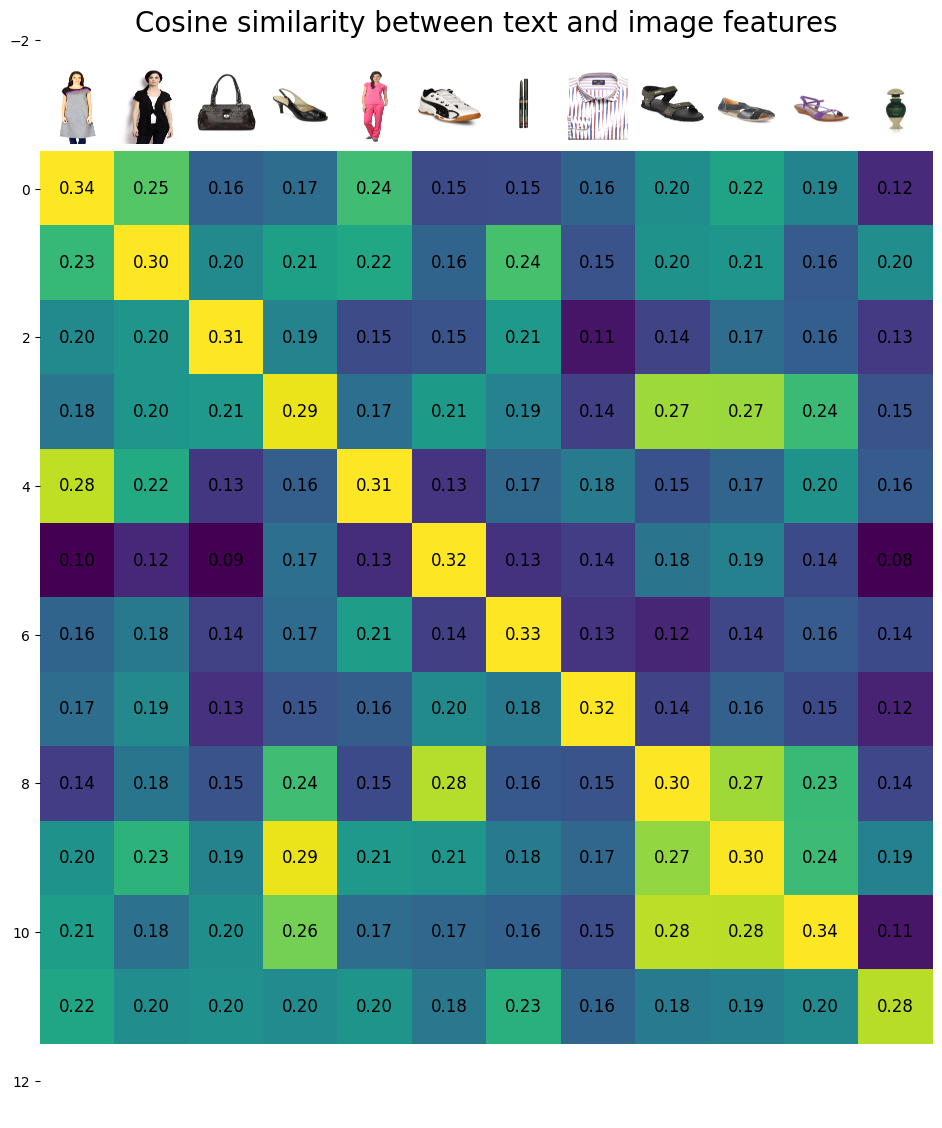

In [ ]:
count = len(descriptions)
plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()  # Décommentez pour afficher la barre de couleur
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)
for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)
plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])
plt.title("Cosine similarity between text and image features", size=20)

# 6. SigLip

In [29]:
from tqdm import tqdm
def top_k_indices(arr, k):
    return np.argsort(arr[-k:])

class Siglip():
    def __init__(self, image_paths, descriptions, model):
      self.image_paths = image_paths
      self.descriptions = descriptions
      self.model = AutoModel.from_pretrained(model)
      self.processor = AutoProcessor.from_pretrained(model)

    def get_text_features(self, batch_size):
      image = Image.open(self.image_paths[0]).convert("RGB")
      text_features = torch.empty(size=(len(self.image_paths), 768))
      for batch in tqdm(range(0, len(self.descriptions), batch_size)):
        texts = self.descriptions[batch:batch+batch_size]
        inputs = self.processor(text=texts, images=image, padding="max_length", return_tensors="pt")
        with torch.no_grad():
            pixel_values = inputs.pixel_values.to(device)
            input_ids = inputs.input_ids.to(device)
            outputs = self.model(**inputs)
            del pixel_values, input_ids
        text_features[batch:batch+batch_size] = outputs.text_embeds
      return text_features

    def get_image_features(self):
      image_features = torch.empty(size=(len(self.image_paths), 768))
      text = self.descriptions[0]
      for idx, image in tqdm(enumerate(self.image_paths)):
        image = Image.open(image).convert("RGB")
        inputs = self.processor(text=text, images=image, padding="max_length", return_tensors="pt")
        with torch.no_grad():
            print("Image features computing")
            pixel_values = inputs.pixel_values.to(device)
            print("Text features computing")
            input_ids = inputs.input_ids.to(device)
            outputs = self.model(**inputs)
            del pixel_values, input_ids
        image_features[idx] = outputs.image_embeds.squeeze(0)
      return image_features

    def image_text_similarity(self, image_path, texts:list[str]):
      image = Image.open(image_path).convert("RGB")
      inputs = self.processor(text=texts, images=image, padding="max_length", return_tensors="pt")
      with torch.no_grad():
        outputs = self.model(**inputs)
      return outputs.text_embeds, outputs.image_embeds

    def text_embedding(self, text:str):
      image = Image.open(self.image_paths[0]).convert("RGB")
      text = [text]
      inputs = self.processor(text=text, images=image, padding="max_length", return_tensors="pt")
      with torch.no_grad():
          pixel_values = inputs.pixel_values.to(device)
          input_ids = inputs.input_ids.to(device)
          outputs = self.model(**inputs)
      description_norm = outputs.text_embeds / outputs.text_embeds.norm(dim=1, keepdim=True)
      return description_norm

In [30]:
my_model = "google/siglip-base-patch16-256-multilingual"
siglip_model = Siglip(image_paths=images_path, descriptions=descriptions, model=my_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
#siglip_image_features = siglip_model.get_image_features()
#torch.save(siglip_image_features, '/content/gdrive/MyDrive/P10/siglip_images_features.pt')

In [30]:
#siglip_text_features = siglip_model.get_text_features(batch_size=500)
#torch.save(siglip_text_features, '/content/gdrive/MyDrive/P10/siglip_texts_features.pt')

100%|██████████| 11/11 [17:50<00:00, 97.31s/it]


In [11]:
siglip_sim = evaluation.get_similarity('/content/gdrive/MyDrive/P10/siglip_images_features.pt', '/content/gdrive/MyDrive/P10/siglip_texts_features.pt')

<ipython-input-5-319073ae91cf>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  text_features = torch.load(text_features_path)
<ipython-input-5-319073ae91cf>:74: FutureWarn

In [13]:
siglip_1_acc = evaluation.top_k_accuracy(siglip_sim, k=1)
siglip_3_acc = evaluation.top_k_accuracy(siglip_sim, k=3)
siglip_5_acc = evaluation.top_k_accuracy(siglip_sim, k=5)

Top-1 Accuracy: 30.61%
Top-3 Accuracy: 49.85%
Top-5 Accuracy: 59.41%


In [10]:
siglip_sim = torch.load('/content/gdrive/MyDrive/P10/siglip_sim_matrix.pt')

<ipython-input-10-79fc8e5aafaf>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  siglip_sim = torch.load('/content/gdrive/MyDrive/P10/siglip_sim_matrix.pt')


In [11]:
indices = np.random.choice(range(42266), 10, replace=False)
selected_sim_matrix = siglip_sim[indices]

In [12]:
top_images_indices = torch.topk(torch.tensor(selected_sim_matrix), 10, dim=1).indices.numpy()

<ipython-input-12-d2eb8c96fb46>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_images_indices = torch.topk(torch.tensor(selected_sim_matrix), 10, dim=1).indices.numpy()


In [19]:
top_images_indices.shape

(10, 10)

In [14]:
import faiss

In [15]:
siglip_images_features = torch.load('/content/gdrive/MyDrive/P10/siglip_images_features.pt')
image_embeddings = siglip_images_features.numpy()

<ipython-input-15-2fec48336271>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  siglip_images_features = torch.load('/content/gdrive/MyDrive/P10/siglip_images_features.pt')

In [20]:
dimension = image_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(image_embeddings)

In [47]:
prompt_text = 'veste noire pour femme pour hiver'
prompt_text_embedding = siglip_model.text_embedding(prompt_text)

In [48]:
prompt_text_embedding_np = prompt_text_embedding.numpy()
k = 3
D, I = index.search(prompt_text_embedding_np, k)

In [49]:
closest_images = [images_path[i] for i in I[0]]

In [50]:
D, I, closest_images

(array([[1.8286754, 1.8323283, 1.8655835]], dtype=float32),
 array([[4725, 5063, 3295]]),
 ['/content/gdrive/MyDrive/P10/fashion-dataset/images/33989.jpg',
  '/content/gdrive/MyDrive/P10/fashion-dataset/images/33991.jpg',
  '/content/gdrive/MyDrive/P10/fashion-dataset/images/51981.jpg'])

In [53]:
Image.open(closest_images[2])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def image_recommandation(text:str, image_path:str, n_reco:int):
  image = Image.open(image_paths[0]).convert("RGB")
  text = [text]
  inputs = processor(text=text, images=image, padding="max_length", return_tensors="pt")
  with torch.no_grad():
      pixel_values = inputs.pixel_values.to(device)
      input_ids = inputs.input_ids.to(device)
      outputs = self.model(**inputs)
      del pixel_values, input_ids
  text_features[batch:batch+batch_size] = outputs.text_embeds
      return text_features

Si la fonction n'a pas de lien avec le modèle on peut le sortir de la logique de la classe.

Expliquer dans la note méthodologique pourquoi les CNN ne sont pas interprétable en tant que tel. CE3 Vous avez explicité l'interprétabilité globale et locale du modèle.

Finetuning : axe d'amélioration.

Interface graphique : montrer des recommandations à partir d'un prompt textuel.

t-SNE : plongements des texts. Pour voir les points similaires en fonctions des catégories de produit.

 Le DataLoader itère sur votre SigLipDataset et regroupe les entrées en batches.

 Ici, chaque batch contient les données transformées de deux images et de toutes les descriptions en texte pour ces images.

 `input_ids`: chaque batch contient les données pour deux images, et chaque image, on a 500 descriptions tokenisées un vecteur de 64 tokens.

`pixel_values`: chaque image a 3 canaux (RGB) et une résolution de 256x256 pixels.